In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Урок 9
## <font color="#00bfff">1. Датасет</font>

In [2]:
df = pd.read_csv('Sem8_data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## <font color="#00bfff">3. Описательная статистика</font>

In [3]:
df["userid"].count() == df["userid"].nunique()

True

$\color{green}Повторяющихся\spaceпользователей\spaceнет$

In [4]:
display(df.groupby("version")[["userid"]].nunique())
n2, n1 = df.version.value_counts()

,userid
version,
gate_30,44700
gate_40,45489


$\color{green}Выборки\spaceприблизительно\spaceодинаковы$

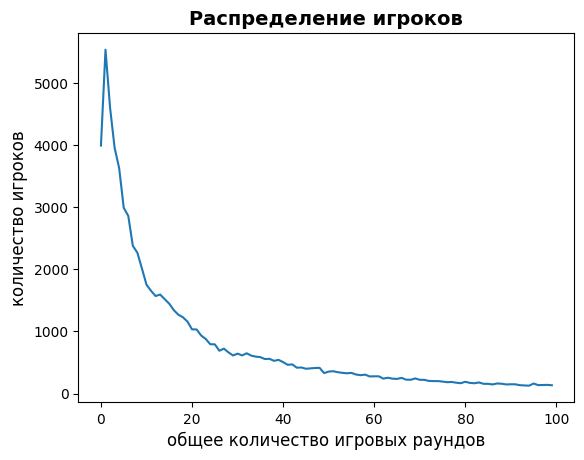

In [5]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("общее количество игровых раундов", size=12)
plt.ylabel("количество игроков", size=12)
plt.show()

На графике выше мы видим, что некоторые игроки устанавливают игру, но никогда не играют в нее (0 игровых раундов). Найдем, сколько их.

In [6]:
df.query("sum_gamerounds == 0").userid.count()

3994

Распространенным в индустрии видеоигр показателем того, насколько увлекательной является игра, является удержание: процент игроков, которые возвращаются и играют в игру через 1 и 7 дней после ее установки. Чем выше показатель удержания, тем легче удержать игроков

In [7]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"Коэффициент удержания за 1 день: {round(df_retention[0],2)}% \
      \nКоэффициент удержания за 7 дней: {round(df_retention[1],2)}%")

Коэффициент удержания за 1 день: 44.52%       
Коэффициент удержания за 7 дней: 18.61%


## <font color="#00bfff">4. Проверка на распределение</font>

In [11]:
df.query('version == "gate_30" and retention_1 == False').sum_gamerounds
display(stats.kstest(df.sum_gamerounds, 'norm'))
display(stats.kstest(df.sum_gamerounds, 'expon'))
display(stats.kstest(df.sum_gamerounds, 'binom', args=(1500, 0.16)))


KstestResult(statistic=0.8715607041848303, pvalue=0.0, statistic_location=2, statistic_sign=-1)

KstestResult(statistic=0.7934532380996653, pvalue=0.0, statistic_location=3, statistic_sign=-1)

KstestResult(statistic=0.9398360749415627, pvalue=0.0, statistic_location=200, statistic_sign=1)

In [14]:
df.query('version == "gate_30" and retention_1 == True and retention_7 == True').userid.count()

6676

In [15]:
df.query('version == "gate_40" and retention_1 == True and retention_7 == True').userid.count()

6506

## <font color="#00bfff"> 5. A/B Bootstrapping тест</font>

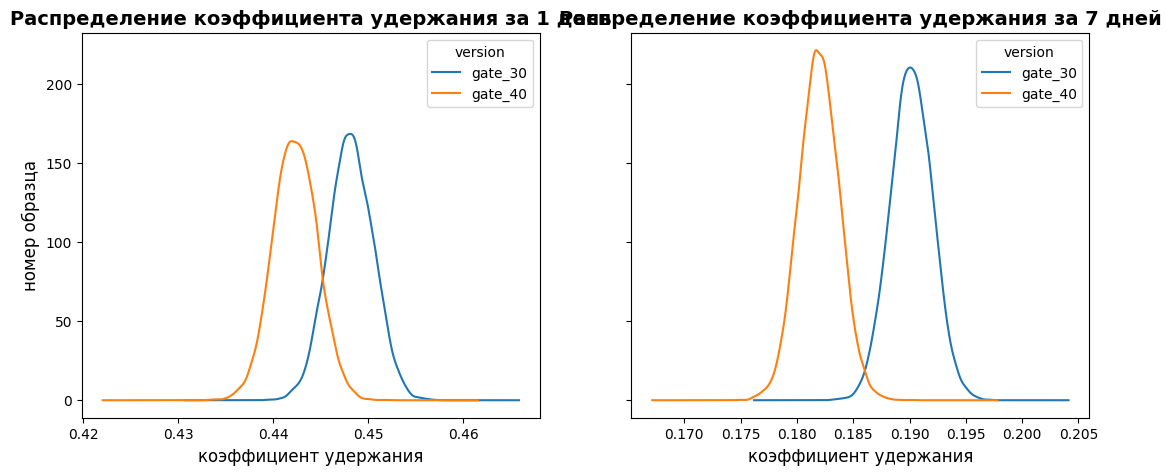

In [16]:
boot_1d = pd.DataFrame([df.sample(frac=1, replace=True).groupby(
    'version')['retention_1'].mean() for _ in range(10000)])
boot_7d = pd.DataFrame([df.sample(frac=1, replace=True).groupby(
    'version')['retention_7'].mean() for _ in range(10000)])

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания", size=12)
ax1.set_ylabel("Кол-во выборок", size=12)
ax1.set_title("Распределение коэффициента удержания за 1 день",
              fontweight="bold", size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания", size=12)
ax2.set_title("Распределение коэффициента удержания за 7 дней",
              fontweight="bold", size=14)
plt.show()


Эти два распределения выше представляют собой бутстрапную неопределенность в отношении того, каким может быть базовое 1-дневное и 7-дневное удержание для двух групп A/B. Просто взглянув на этот график, мы видим, что, кажется, есть некоторые признаки разницы, хотя и небольшой. Давайте увеличим различия

#### Добавление столбца с разницей в % между двумя группами A/B

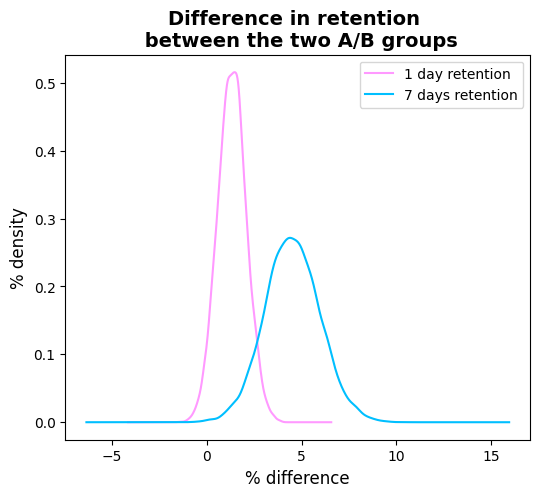

In [17]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

Из этой диаграммы видно, что наиболее вероятная разница в процентах составляет около 1–2% для 1-дневного удержания. Для 7-дневного удержания наиболее вероятная разница в процентах составляет около 2–5%. Причем большая часть распределения выше 0%, в пользу ворот на 30 уровне. Но какова вероятность, что разница выше 0%? Давайте посчитаем и это.

In [18]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f"Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: {(prob_7)*100}% ")

Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: 96.0%       
Вероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: 99.91% 


## <font color="00bfff">6. Вывод</font>

Результат bootstrap теста говорит нам о том, что существуют убедительные доказательства **99,8% вероятности** того, что 7-дневное удержание выше, когда ворота находятся на уровне 30, чем когда они находятся на уровне 40.

Вывод таков: если мы хотим поддерживать высокий уровень удержания — как за 1, так и за 7 дней — мы не должны  перемещать ворота с уровня 30 на уровень 40. Конечно, есть и другие показатели. мы могли бы посмотреть, например, на количество сыгранных игровых раундов или количество внутриигровых покупок, сделанных двумя AB-группами. Но удержание *является* одним из самых важных показателей.